In [15]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [16]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

In [17]:
inWidth = 368
inHeight = 368
thr = 0.2

In [18]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [19]:
img = cv.imread("data/pose1.jpg")

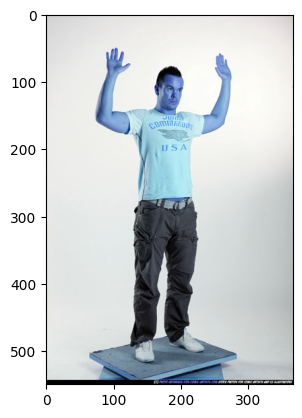

In [20]:
plt.imshow(img)

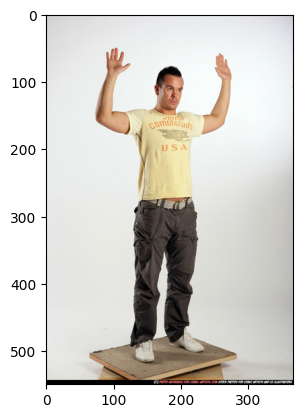

In [21]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [22]:
#255/2 = 127.5
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        print(f"Body part {i}: Confidence = {conf}, Point = {point}")
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame

In [23]:
estimated_image = pose_estimation(img)

Body part 0: Confidence = 0.7063313722610474, Point = (23, 10)
Body part 1: Confidence = 0.6726978421211243, Point = (23, 13)
Body part 2: Confidence = 0.5386507511138916, Point = (18, 13)
Body part 3: Confidence = 0.3026980757713318, Point = (12, 13)
Body part 4: Confidence = 0.10182499140501022, Point = (33, 7)
Body part 5: Confidence = 0.4709925353527069, Point = (26, 13)
Body part 6: Confidence = 0.4213835299015045, Point = (31, 12)
Body part 7: Confidence = 0.12100501358509064, Point = (33, 7)
Body part 8: Confidence = 0.5948360562324524, Point = (20, 24)
Body part 9: Confidence = 0.4244673252105713, Point = (19, 33)
Body part 10: Confidence = 0.37972891330718994, Point = (18, 39)
Body part 11: Confidence = 0.5718606114387512, Point = (25, 24)
Body part 12: Confidence = 0.6203016042709351, Point = (25, 33)
Body part 13: Confidence = 0.7371795177459717, Point = (24, 39)
Body part 14: Confidence = 0.761066734790802, Point = (23, 9)
Body part 15: Confidence = 0.841649055480957, Point

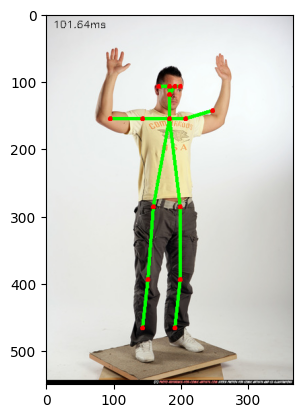

In [24]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [25]:
#Video

#This code performs real-time pose estimation on a video using OpenCV’s DNN (Deep Neural Network) module with a pre-trained TensorFlow model. 
#It starts by attempting to open a video file (pose_estimation_video.mp4), and if unsuccessful, it defaults to capturing video from the system's webcam. 
#The video feed is processed frame by frame in a loop, where each frame is converted into a blob format suitable for the neural network using cv.dnn.blobFromImage(). 
#The pre-trained model performs a forward pass on the frame, generating keypoints for different body parts. 
#These keypoints are extracted based on confidence values, and if they meet the threshold, they are added to a list. 
#Lines are drawn between connected keypoints to form a skeleton, and ellipses are placed at the keypoint locations to visualize the detected body parts. 
#Additionally, the code measures the time taken to process each frame and displays it in milliseconds on the video feed. 
#Finally, the processed video frames with the overlaid skeleton are displayed in real-time using cv.imshow().


In [26]:
#perform this demo on video
#from google.colab.patches import cv2_imshow
cap = cv.VideoCapture('pose_estimation_video.mp4')
cap.set(3,800) #height
cap.set(4,800) #width

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")

while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        print(f"Body part {i}: Confidence = {conf}, Point = {point}")
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('Pose Estimation Tutorial', frame)
    
        

Body part 0: Confidence = 0.004943431355059147, Point = (43, 41)
Body part 1: Confidence = 0.009622283279895782, Point = (43, 0)
Body part 2: Confidence = 0.01239193044602871, Point = (43, 43)
Body part 3: Confidence = 0.013407937251031399, Point = (45, 0)
Body part 4: Confidence = 0.012827092781662941, Point = (0, 0)
Body part 5: Confidence = 0.01190381869673729, Point = (42, 0)
Body part 6: Confidence = 0.01169370673596859, Point = (43, 45)
Body part 7: Confidence = 0.008172806352376938, Point = (43, 44)
Body part 8: Confidence = 0.007326409220695496, Point = (43, 45)
Body part 9: Confidence = 0.006096227094531059, Point = (44, 1)
Body part 10: Confidence = 0.006040271371603012, Point = (43, 2)
Body part 11: Confidence = 0.016798235476017, Point = (45, 0)
Body part 12: Confidence = 0.005331526510417461, Point = (43, 0)
Body part 13: Confidence = 0.008616387844085693, Point = (45, 1)
Body part 14: Confidence = 0.010001040995121002, Point = (44, 45)
Body part 15: Confidence = 0.0106547

KeyboardInterrupt: 

In [ ]:
#This code performs real-time pose estimation using a webcam feed with OpenCV’s DNN module and a pre-trained TensorFlow model. 
#The script first attempts to open the camera feed from the secondary webcam (cv.VideoCapture(1)), and if this fails, it defaults to the primary camera (cv.VideoCapture(0)). 
#If no camera is available, an error is raised. The video feed is processed frame by frame in a loop. 
#For each frame, the image dimensions are obtained, and the frame is converted into a blob suitable for neural network input using cv.dnn.blobFromImage(). 
#The pose estimation model performs a forward pass on the frame, and keypoints for various body parts are extracted based on confidence scores. 
#These keypoints are stored and, if they meet a threshold, connected to form a skeleton using lines and ellipses. 
#The code also calculates and displays the inference time in milliseconds on the video frame. 
#The processed video with the overlaid skeleton is displayed in real-time using cv.imshow(). The loop runs until a key is pressed or the video feed is interrupted.

In [ ]:
#camera
#perform this demo on video
#from google.colab.patches import cv2_imshow
cap = cv.VideoCapture(1)
cap.set(3,800) #height
cap.set(4,800) #width

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        print(f"Body part {i}: Confidence = {conf}, Point = {point}")
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('Pose Estimation Tutorial', frame)
    
        

In [ ]:
import cv2 as cv
import numpy as np

# Load the pre-trained neural network model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") 

# Set the input size for the network
inWidth = 368
inHeight = 368
thr = 0.2  

# Define the BODY_PARTS and POSE_PAIRS
BODY_PARTS = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
              5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
              10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
              15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
              ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
              ["Neck", "Nose"], ["Nose", "REye"], ["REye", "REar"],
              ["Nose", "LEye"], ["LEye", "LEar"]]

# Define the pose_estimation function
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        points.append((int(x), int(y)) if conf > thr else None)

    return points

# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Function to calculate the similarity percentage between two sets of keypoints
def calculate_similarity_percentage(keypoints1, keypoints2, max_distance=200):
    if len(keypoints1) != len(keypoints2):
        raise ValueError("Keypoints from both images must have the same length.")
    
    total_distance = 0
    valid_points = 0

    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 is not None and kp2 is not None:
            total_distance += euclidean_distance(kp1, kp2)
            valid_points += 1

    if valid_points == 0:
        return 0  # No valid points to compare

    average_distance = total_distance / valid_points
    similarity_percentage = max(0, 100 * (1 - average_distance / max_distance))
    
    return similarity_percentage

# Load the first image and extract keypoints
img = cv.imread("pose2.jpg")
keypoints_img1 = pose_estimation(img)

# Load the second image and extract keypoints
img2 = cv.imread("pose.jpg")
keypoints_img2 = pose_estimation(img2)

# Calculate the similarity percentage between the two sets of keypoints
similarity_percentage = calculate_similarity_percentage(keypoints_img1, keypoints_img2)

print(f"The similarity between the two poses is {similarity_percentage:.2f}%")


The similarity between the two poses is 0.00%


In [ ]:
#This code performs pose estimation and matching on two images using OpenCV’s DNN module with a pre-trained TensorFlow model. 
#The pose_estimation function extracts keypoints for 18 body parts (like the nose, shoulders, and hips) from each image, and visualizes them by drawing skeletons using lines and ellipses. 
#The keypoints from both images are compared using Euclidean distance, and the calculate_similarity_percentage function calculates a similarity score between the two poses. 
#The images are resized to the same height for comparison, and the two skeleton-overlaid images are combined side by side. 
#The similarity percentage is displayed on the combined image, which is then shown using Matplotlib. 
#This allows for both a visual and quantitative assessment of how closely the two poses match.

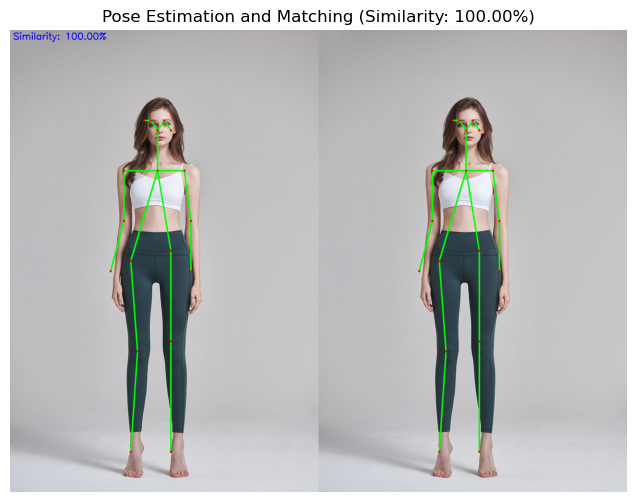

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained neural network model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Set the input size for the network
inWidth = 368
inHeight = 368
thr = 0.2

# Define the BODY_PARTS with names as keys
BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
              ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
              ["Neck", "Nose"], ["Nose", "REye"], ["REye", "REar"],
              ["Nose", "LEye"], ["LEye", "LEar"]]

# Pose estimation function with skeleton drawing
def pose_estimation(frame):
    if frame is None:
        raise ValueError("The image could not be loaded. Please check the file path.")
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        
        # Only consider points with confidence above threshold
        points.append((int(x), int(y)) if conf > thr else None)

    # Draw skeleton
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return points, frame

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Function to calculate similarity percentage between two sets of keypoints
def calculate_similarity_percentage(keypoints1, keypoints2, max_distance=200):
    total_distance = 0
    valid_points = 0

    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 is not None and kp2 is not None:
            total_distance += euclidean_distance(kp1, kp2)
            valid_points += 1

    if valid_points == 0:
        return 0  # No valid points to compare

    average_distance = total_distance / valid_points
    similarity_percentage = max(0, 100 * (1 - average_distance / max_distance))
    
    return similarity_percentage

# Function to resize images to the same height
def resize_to_same_height(img1, img2):
    height1 = img1.shape[0]
    height2 = img2.shape[0]

    if height1 != height2:
        # Resize the second image to match the first image's height
        img2 = cv.resize(img2, (int(img2.shape[1] * (height1 / height2)), height1))

    return img1, img2

# Load and process the first image
img1 = cv.imread("pose4.jpg")
if img1 is None:
    print("Error loading pose4.jpg")

keypoints_img1, img1_with_pose = pose_estimation(img1)

# Load and process the second image
img2 = cv.imread("pose4.jpg")  # Changed file to "pose2.jpg" for comparison
if img2 is None:
    print("Error loading pose2.jpg")

keypoints_img2, img2_with_pose = pose_estimation(img2)

# Resize images to have the same height
img1_with_pose, img2_with_pose = resize_to_same_height(img1_with_pose, img2_with_pose)

# Calculate the similarity percentage between the two poses
similarity_percentage = calculate_similarity_percentage(keypoints_img1, keypoints_img2)

# Combine both images side by side
combined_image = np.hstack((img1_with_pose, img2_with_pose))

# Add similarity percentage text to the combined image
cv.putText(combined_image, f"Similarity: {similarity_percentage:.2f}%", (10, 30),
           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

# Convert BGR to RGB for matplotlib
combined_image_rgb = cv.cvtColor(combined_image, cv.COLOR_BGR2RGB)

# Display the combined image using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(combined_image_rgb)
plt.title(f"Pose Estimation and Matching (Similarity: {similarity_percentage:.2f}%)")
plt.axis("off")  # Hide the axis
plt.show()
